- change validation scheme

In [1]:
import sys
import copy
import random
import feather
import warnings
import numpy as np
import pandas as pd
from time import time
import lightgbm as lgb
from collections import Counter
from sklearn import preprocessing
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
from tqdm._tqdm_notebook import tqdm_notebook

import riiideducation
warnings.filterwarnings("ignore")
tqdm_notebook.pandas(desc="progress: ")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [2]:
DIR = "../input/riiid-test-answer-prediction/"
train = pd.read_feather("../input/riid-train/train.feather")
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")

In [3]:
lecture_id = list(lectures.lecture_id.unique())
lectures['type_of'] = lectures['type_of'].replace('solving question', 'solving_question')
lectures = pd.get_dummies(lectures, columns=['type_of'])

types_columns = [column for column in lectures.columns if column.startswith('type_of_')]

In [4]:
train.shape

(101230332, 10)

# preprocess

In [5]:
# executed in advance
train = train.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
train.drop(["row_id", "user_answer", "timestamp", 'task_container_id'], axis=1, inplace=True)

In [6]:
print("consider lecture data")
user_lec_df = train.groupby('user_id').agg({'content_type_id': ['mean']}).copy()
user_lec_df.columns = ["lec_ratio"]

train["lec"] = train.groupby(["user_id"])['content_type_id'].progress_apply(lambda x: x.shift(1))
train.drop(["content_type_id"], axis=1, inplace=True)

#train = train.merge(lectures[["lecture_id"]+types_columns], how="left", left_on=['content_id'], right_on=['lecture_id']).drop(columns='lecture_id')
#user_lec_type = train.groupby("user_id").agg("mean")[types_columns]
#user_lec_type = user_lec_type.fillna(0)

print("remove lecture data")
train = train.loc[train['answered_correctly'] != -1].reset_index(drop=True)

print("merge question data")
# https://stackoverflow.com/questions/25888207/pandas-join-dataframes-on-field-with-different-names
train = train.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
train.drop(["question_id"], axis=1, inplace=True)

print("groupby calculation")
user_answers_df = train.groupby('user_id').agg({'answered_correctly': ['mean']}).copy()
user_answers_df.columns = ["acc_before_ans"]

user_answers_past2 = pd.DataFrame(train.groupby("user_id").tail(2).groupby("user_id").agg("mean")["answered_correctly"])
user_answers_past2.columns = ["mean_of_last_2_answered_correctly_by_user_id"]
user_answers_past3 = pd.DataFrame(train.groupby("user_id").tail(3).groupby("user_id").agg("mean")["answered_correctly"])
user_answers_past3.columns = ["mean_of_last_3_answered_correctly_by_user_id"]

user_part_accuracy = train.groupby(['user_id', 'part']).agg({'answered_correctly': ['mean']}).copy().unstack()
user_part_accuracy.columns = ["part1_acc", "part2_acc", "part3_acc", "part4_acc", "part5_acc", "part6_acc", "part7_acc"]

user_lec_ratio = train.groupby(['user_id']).agg({'lec': ['mean']}).copy()
user_lec_ratio.columns = ["lec"]

mean_accuracy_by_part = np.array([0.74503238, 0.70869406, 0.70145593, 0.63099758, 0.61008792, 0.66938835, 0.65960112])

consider lecture data



remove lecture data
merge question data
groupby calculation


In [7]:
#to get first index of a particular user
for i in train.groupby("user_id").first().index:
    if i > 88000000:
        print(i)
        break

88006297


In [8]:
train = train.iloc[88006297:,:]
#train['task_container_id'] = train.groupby('user_id')['task_container_id'].transform(lambda x: pd.factorize(x)[0]).astype('int16')
train["lec"] = train["lec"].fillna(0)
print(train.shape, len(train.user_id.unique()))
train.head(10)

(11265003, 7) 44384


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lec,part
88006297,1907098099,5335,1,14000,True,0.0,5
88006298,1907098099,8930,1,26000,True,0.0,5
88006299,1907098099,5960,0,25000,True,0.0,5
88006300,1907098099,4464,1,30000,True,0.0,5
88006301,1907098099,6263,1,25000,True,0.0,5
88006302,1907098099,9192,1,16000,True,0.0,5
88006303,1907098099,4414,1,13000,True,0.0,5
88006304,1907098099,9312,1,8000,True,0.0,5
88006305,1907098099,4476,1,41000,True,0.0,5
88006306,1907098099,9672,1,5000,True,0.0,5


# Feature engineering

In [9]:
%%time
def get_data(df, test_set=False):
    if test_set == False:
        
        # cumsum correct answer by user_id
        tmp1 = df.groupby(['user_id'])['answered_correctly'].apply(lambda x: pd.concat([pd.DataFrame([0]), x.cumsum()[:-1]])).reset_index(drop=True).values
        tmp1 = np.array(tmp1, dtype=float)
        # cumsum total try by user_id
        tmp2 = df.groupby(['user_id']).cumcount().values
        tmp2 = np.array(tmp2, dtype=float).reshape(-1,1)
        # https://stackoverflow.com/questions/26248654/how-to-return-0-with-divide-by-zero
        correct_rate = np.divide(tmp1, tmp2, out=np.ones_like(tmp1)*-1, where=tmp2!=0)
        
        # cumsum lec count by user_id 
        tmp1 = df.groupby(['user_id'])['lec'].apply(lambda x: x.cumsum()).reset_index(drop=True).values
        tmp1 = np.array(tmp1, dtype=float).reshape(-1,1)
        lec_rate = np.divide(tmp1, tmp2, out=np.zeros_like(tmp1), where=tmp2!=0)
        
        # cumsum of each part trial by user
        part1_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part2_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==2).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part3_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==3).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part4_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==4).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part5_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==5).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part6_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==6).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part7_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==7).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values

        # logical bool if part is matched by user
        part1_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==1))
        part2_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==2))
        part3_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==3))
        part4_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==4))
        part5_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==5))
        part6_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==6))
        part7_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==7))
        # logical bool if answer is correct by user
        acc_g = pd.DataFrame(df.groupby(["user_id"])['answered_correctly'].apply(lambda x: x==1))

        # cumsum of correct num per part by user
        part1_acc_cumsum = np.logical_and(acc_g.values ,part1_g.values)
        part2_acc_cumsum = np.logical_and(acc_g.values ,part2_g.values)
        part3_acc_cumsum = np.logical_and(acc_g.values ,part3_g.values)
        part4_acc_cumsum = np.logical_and(acc_g.values ,part4_g.values)
        part5_acc_cumsum = np.logical_and(acc_g.values ,part5_g.values)
        part6_acc_cumsum = np.logical_and(acc_g.values ,part6_g.values)
        part7_acc_cumsum = np.logical_and(acc_g.values ,part7_g.values)

        df["part1_and_ok"] = part1_acc_cumsum
        df["part2_and_ok"] = part2_acc_cumsum
        df["part3_and_ok"] = part3_acc_cumsum
        df["part4_and_ok"] = part4_acc_cumsum 
        df["part5_and_ok"] = part5_acc_cumsum
        df["part6_and_ok"] = part6_acc_cumsum
        df["part7_and_ok"] = part7_acc_cumsum
        
        part1_acc_cumsum = df.groupby(["user_id"])['part1_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part2_acc_cumsum = df.groupby(["user_id"])['part2_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part3_acc_cumsum = df.groupby(["user_id"])['part3_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part4_acc_cumsum = df.groupby(["user_id"])['part4_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part5_acc_cumsum = df.groupby(["user_id"])['part5_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part6_acc_cumsum = df.groupby(["user_id"])['part6_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part7_acc_cumsum = df.groupby(["user_id"])['part7_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values

        part1_acc_cumsum = np.array(part1_acc_cumsum, dtype=float)
        part2_acc_cumsum = np.array(part2_acc_cumsum, dtype=float)
        part3_acc_cumsum = np.array(part3_acc_cumsum, dtype=float)
        part4_acc_cumsum = np.array(part4_acc_cumsum, dtype=float)
        part5_acc_cumsum = np.array(part5_acc_cumsum, dtype=float)
        part6_acc_cumsum = np.array(part6_acc_cumsum, dtype=float)
        part7_acc_cumsum = np.array(part7_acc_cumsum, dtype=float)
        
        part1_acc_rate = np.divide(part1_acc_cumsum, part1_cumsum, out=np.ones_like(part1_acc_cumsum)*-1, where=part1_cumsum!=0)
        part2_acc_rate = np.divide(part2_acc_cumsum, part2_cumsum, out=np.ones_like(part2_acc_cumsum)*-1, where=part2_cumsum!=0)
        part3_acc_rate = np.divide(part3_acc_cumsum, part3_cumsum, out=np.ones_like(part3_acc_cumsum)*-1, where=part3_cumsum!=0)
        part4_acc_rate = np.divide(part4_acc_cumsum, part4_cumsum, out=np.ones_like(part4_acc_cumsum)*-1, where=part4_cumsum!=0)
        part5_acc_rate = np.divide(part5_acc_cumsum, part5_cumsum, out=np.ones_like(part5_acc_cumsum)*-1, where=part5_cumsum!=0)
        part6_acc_rate = np.divide(part6_acc_cumsum, part6_cumsum, out=np.ones_like(part6_acc_cumsum)*-1, where=part6_cumsum!=0)
        part7_acc_rate = np.divide(part7_acc_cumsum, part7_cumsum, out=np.ones_like(part7_acc_cumsum)*-1, where=part7_cumsum!=0)
                    
        df["acc_before_ans"] = correct_rate
        df["part1_acc"] = part1_acc_rate
        df["part2_acc"] = part2_acc_rate
        df["part3_acc"] = part3_acc_rate
        df["part4_acc"] = part4_acc_rate
        df["part5_acc"] = part5_acc_rate
        df["part6_acc"] = part6_acc_rate
        df["part7_acc"] = part7_acc_rate  
        df['prior_question_had_explanation'] = df['prior_question_had_explanation'].fillna(value = False).astype(bool)
        df["lec"] = lec_rate
        
    else:
        df = df.merge(user_answers_df, how = 'left', on = 'user_id') # for acc_before_ans
        df = df.merge(user_part_accuracy, how = 'left', on = 'user_id')
        df = df.merge(user_answers_past2, how = 'left', on = 'user_id')
        df = df.merge(user_answers_past3, how = 'left', on = 'user_id')
        df = df.merge(user_lec_ratio, how = 'left', on = 'user_id')
        df.drop(["timestamp"], axis=1, inplace=True)
    
    df.fillna(value = 0.5, inplace = True) #0?
    return df
train = get_data(train)

CPU times: user 15min 57s, sys: 14 s, total: 16min 11s
Wall time: 16min 5s


In [10]:
# target encoding + moving average not to cause target leakage
AGGS = [
    ('answered_correctly', 2, ['user_id'], ['mean']),
    ('answered_correctly', 3, ['user_id'], ['mean']),
]

for on, lag, by, hows in AGGS:
    agg = train.groupby(by)[on].apply(lambda x: (
        x.shift(1).rolling(window=lag, min_periods=1).agg(hows)
    ))
    agg = agg.rename(columns={
        how: f'{how}_of_last_{lag}_{on}_by_' + '_and_'.join(by)
        for how in hows
    })

    train = train.join(agg)

In [11]:
target = 'answered_correctly'
columns = ["acc_before_ans", 'content_id', 'part', 'prior_question_had_explanation', 'prior_question_elapsed_time',
          "part1_acc",  "part2_acc", "part3_acc", "part4_acc", "part5_acc", "part6_acc", "part7_acc",
           "mean_of_last_2_answered_correctly_by_user_id", "mean_of_last_3_answered_correctly_by_user_id", "lec"]
others = ["user_id"]

drop_columns = [i for i in train.columns if i not in columns + [target] + others]
train.drop(drop_columns, axis=1, inplace=True)

# modelling

In [12]:
val_index = train.groupby("user_id").tail(70).index
train.drop(others, axis=1, inplace=True)
X_valid = train.loc[val_index,:].copy()
X_train = train.loc[~train.index.isin(val_index)]
print(X_train.shape, X_valid.shape)
del train

(9229171, 16) (2035832, 16)


In [13]:
y_train = X_train[target]
X_train.drop(target, axis=1, inplace=True)
y_valid = X_valid[target]
X_valid.drop(target, axis=1, inplace=True)

In [14]:
categoricals = ["content_id", "part"]
params = {'objective': 'binary', "metric": 'auc','eval_metric':'auc', 'boosting_type': 'gbdt', 
          'tree_learner': 'serial', 'learning_rate': 0.1,  "num_leaves": 80 } 

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
        
model = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval], 
        num_boost_round=550,early_stopping_rounds=10,verbose_eval = 10, categorical_feature=categoricals,)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.702946	valid_1's auc: 0.704895
[20]	training's auc: 0.720602	valid_1's auc: 0.717779
[30]	training's auc: 0.732862	valid_1's auc: 0.727156
[40]	training's auc: 0.742005	valid_1's auc: 0.734665
[50]	training's auc: 0.747296	valid_1's auc: 0.739062
[60]	training's auc: 0.751141	valid_1's auc: 0.74157
[70]	training's auc: 0.754243	valid_1's auc: 0.743627
[80]	training's auc: 0.756883	valid_1's auc: 0.745385
[90]	training's auc: 0.759056	valid_1's auc: 0.746619
[100]	training's auc: 0.760775	valid_1's auc: 0.747468
[110]	training's auc: 0.762189	valid_1's auc: 0.748084
[120]	training's auc: 0.7635	valid_1's auc: 0.748618
[130]	training's auc: 0.764747	valid_1's auc: 0.748928
[140]	training's auc: 0.765839	valid_1's auc: 0.749307
[150]	training's auc: 0.766706	valid_1's auc: 0.749494
[160]	training's auc: 0.767585	valid_1's auc: 0.749694
[170]	training's auc: 0.768581	valid_1's auc: 0.749968
[180]	training's

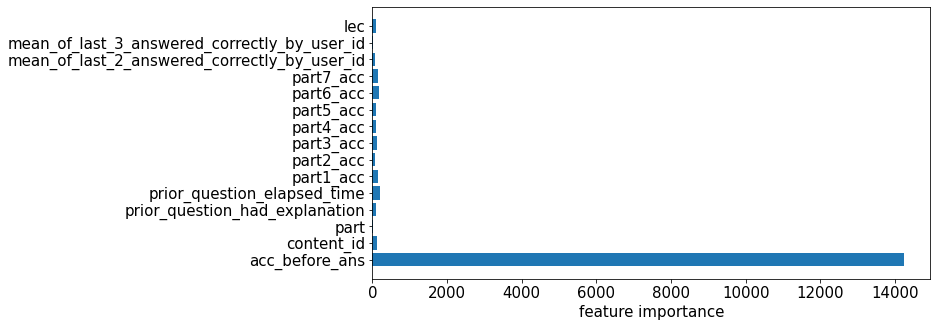

In [15]:
features_list = [i for i in columns]
feature_importance_df = pd.DataFrame(features_list, columns=["Feature"])
feature_importance_df["Importance"] = model.feature_importance()

plt.rcParams.update({'font.size': 15})
x = list(feature_importance_df["Feature"].values)
y = feature_importance_df["Importance"].values

x_position = np.arange(len(x))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.barh(x_position, y, tick_label=x)
ax.set_xlabel('feature importance')
plt.show()

# prediction

In [16]:
del X_train, X_valid, y_train, y_valid

In [17]:
env = riiideducation.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    y_preds = []
    test_df = test_df.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
    test_df.drop(["question_id"], axis=1, inplace=True)

    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
    test_df = get_data(test_df, test_set=True)

    #for model in models:
    y_pred = model.predict(test_df[columns], num_iteration=model.best_iteration)
    y_preds.append(y_pred)

    y_preds = sum(y_preds) / len(y_preds)
    test_df['answered_correctly'] = y_preds
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])